/Users/rakibabdullah/Desktop/4-2/CSE472/ProjectML/code/DeepCMorph/model.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_checkpoints, ma

Model loaded, unexpected keys: []
                Cancer_Type   Area  Eccentricity  Perimeter   Density
0  Adrenocortical_carcinoma   40.0      0.640163  22.242641  1.798348
1  Adrenocortical_carcinoma   90.0      0.430945  33.313708  2.701590
2  Adrenocortical_carcinoma  133.0      0.828903  44.627417  2.980231
3  Adrenocortical_carcinoma   89.0      0.714806  33.556349  2.652255
4  Adrenocortical_carcinoma  114.0      0.761654  39.213203  2.907184
                                                          Area  Eccentricity  \
Cancer_Type                                                                    
Adrenocortical_carcinoma                             80.208333      0.691408   
Bladder_Urothelial_Carcinoma                        240.301205      0.745463   
Brain_Lower_Grade_Glioma                            114.632653      0.695885   
Breast_invasive_carcinoma                           139.784810      0.786283   
Cervical_squamous_cell_carcinoma_and_endocervic...  206.779221    

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/3341140800.py:81: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1152x432 with 0 Axes>

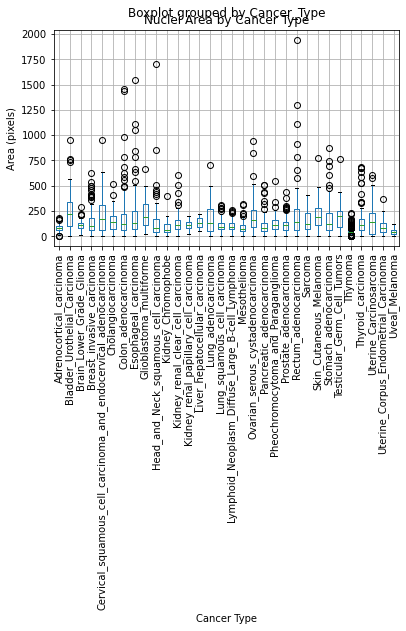

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/3341140800.py:90: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1152x432 with 0 Axes>

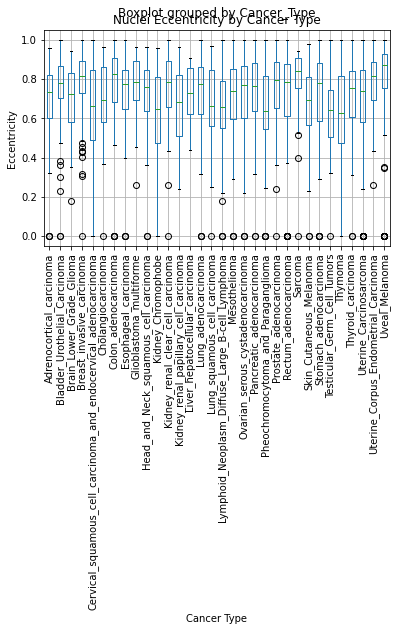

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from model import DeepCMorph
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Step 1: Load the Model and Dataset
NUM_CLASSES = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH_TO_SAMPLE_FOLDER = "data/sample_TCGA_images/"

# Initialize the DeepCMorph model
model = DeepCMorph(num_classes=NUM_CLASSES)
model.load_weights(dataset="TCGA")
model.to(DEVICE)
model.eval()

# Prepare the dataset
test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(PATH_TO_SAMPLE_FOLDER, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Step 2: Generate Segmentation Maps
segmentation_results = []
labels = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(DEVICE)
        segmentation_map, _ = model(images, return_segmentation_maps=True)  # Get segmentation maps
        segmentation_map = segmentation_map.cpu().numpy()[0, 0]  # Extract the first channel
        segmentation_results.append(segmentation_map)
        labels.append(test_dataset.classes[targets.item()])  # Map to cancer type

# Step 3: Analyze Morphological Features
data = []

for idx, segmentation_map in enumerate(segmentation_results):
    # Convert segmentation map to binary mask
    binary_mask = (segmentation_map > 0.5).astype(np.uint8)
    
    # Label connected regions
    labeled_mask = label(binary_mask)
    
    for region in regionprops(labeled_mask):
        # Calculate morphological features
        area = region.area
        eccentricity = region.eccentricity
        perimeter = region.perimeter
        density = area / (perimeter + 1e-6)  # Avoid division by zero
        
        # Save the features with the associated cancer type
        data.append({
            "Cancer_Type": labels[idx],
            "Area": area,
            "Eccentricity": eccentricity,
            "Perimeter": perimeter,
            "Density": density
        })

# Step 4: Convert to DataFrame and Perform Analysis
df = pd.DataFrame(data)
print(df.head())

# Group by cancer type and calculate summary statistics
grouped = df.groupby("Cancer_Type").mean()
print(grouped)

# Step 5: Visualize the Results
# Example: Boxplot for area
plt.figure(figsize=(26, 16))
df.boxplot(column="Area", by="Cancer_Type", rot=90)
plt.title("Nuclei Area by Cancer Type")
plt.ylabel("Area (pixels)")
plt.xlabel("Cancer Type")
plt.tight_layout()
plt.show()

# Example: Boxplot for eccentricity
plt.figure(figsize=(16, 6))
df.boxplot(column="Eccentricity", by="Cancer_Type", rot=90)
plt.title("  Eccentricity by Cancer Type")
plt.ylabel("Eccentricity")
plt.xlabel("Cancer Type")
plt.tight_layout()
plt.show()

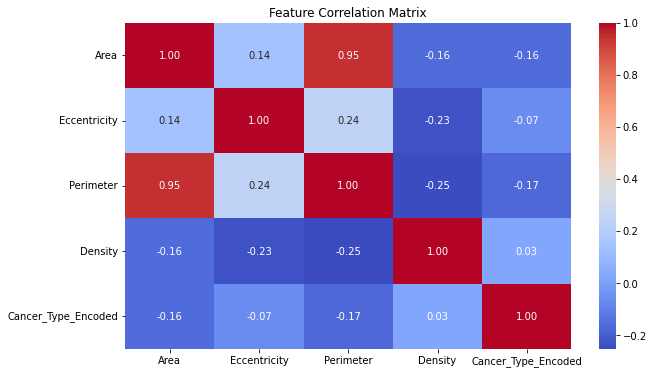

ANOVA Results:
        Feature    F-Value       P-Value
0          Area  18.659447  1.391759e-92
1  Eccentricity   6.344277  4.940086e-25
2     Perimeter  14.979240  1.297311e-72
3       Density   2.672205  1.656302e-06

Random Forest Feature Importance:
        Feature  Importance
1  Eccentricity    0.305370
3       Density    0.268403
2     Perimeter    0.221610
0          Area    0.204618


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/17962524.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=rf_feature_importance, palette="viridis")


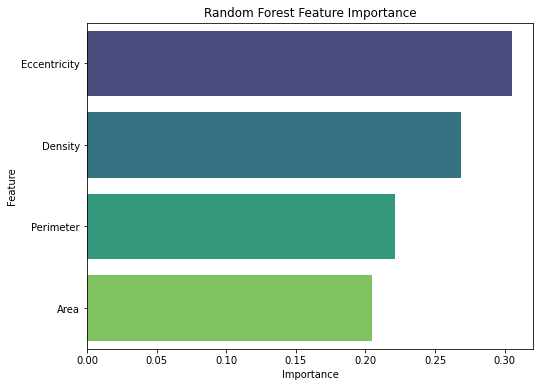

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif

# Step 1: Encode cancer types as numerical labels
df["Cancer_Type_Encoded"] = LabelEncoder().fit_transform(df["Cancer_Type"])

# Step 2: Correlation Analysis
correlation_matrix = df.drop("Cancer_Type", axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Step 3: ANOVA Test for Feature Importance
X = df[["Area", "Eccentricity", "Perimeter", "Density"]]  # Features
y = df["Cancer_Type_Encoded"]  # Target
f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    "Feature": ["Area", "Eccentricity", "Perimeter", "Density"],
    "F-Value": f_values,
    "P-Value": p_values
})
print("ANOVA Results:")
print(anova_results)

# Step 4: Random Forest Feature Importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)
rf_feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)

# Plot Random Forest Feature Importance
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=rf_feature_importance, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

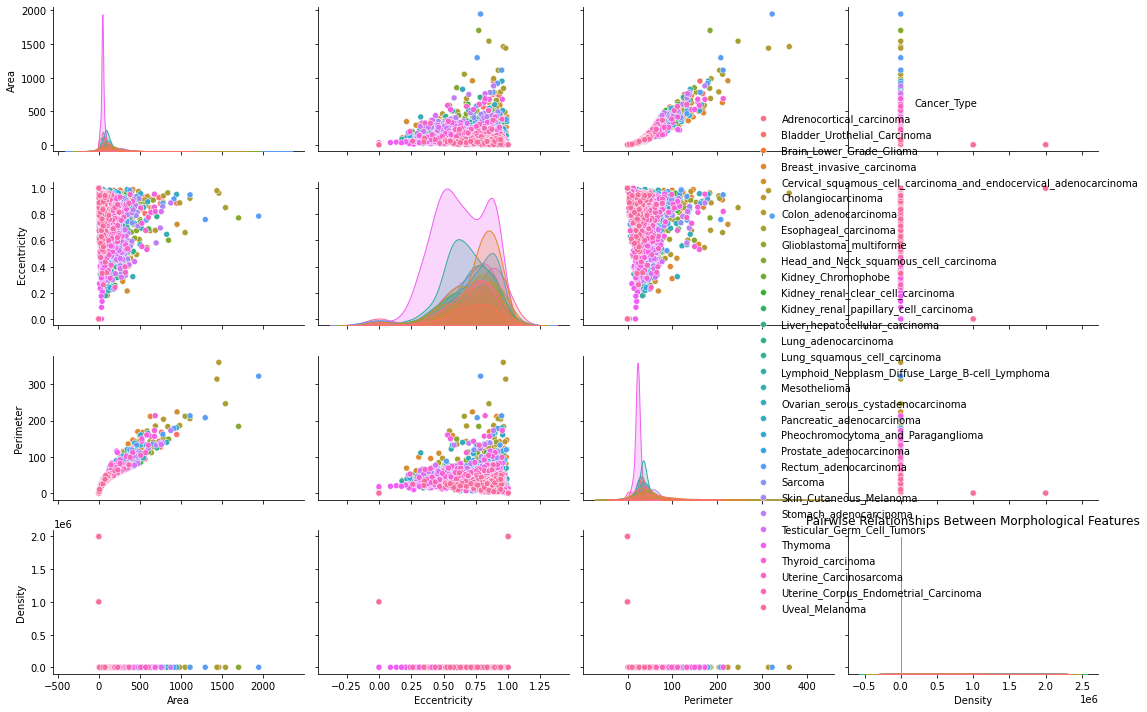

In [4]:
sns.pairplot(df, hue="Cancer_Type", vars=["Area", "Eccentricity", "Perimeter", "Density"], palette="husl", height=2.5)
plt.title("Pairwise Relationships Between Morphological Features")
plt.tight_layout()
plt.show()

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/1423303821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Cancer_Type", y=feature, data=df, palette="muted")


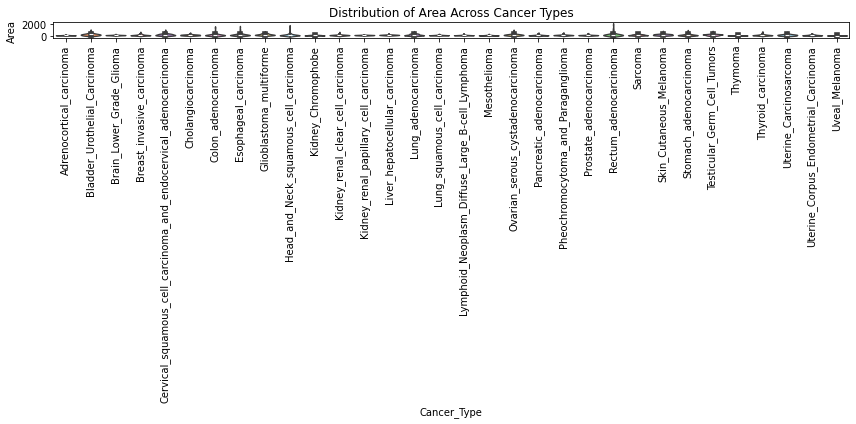

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/1423303821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Cancer_Type", y=feature, data=df, palette="muted")


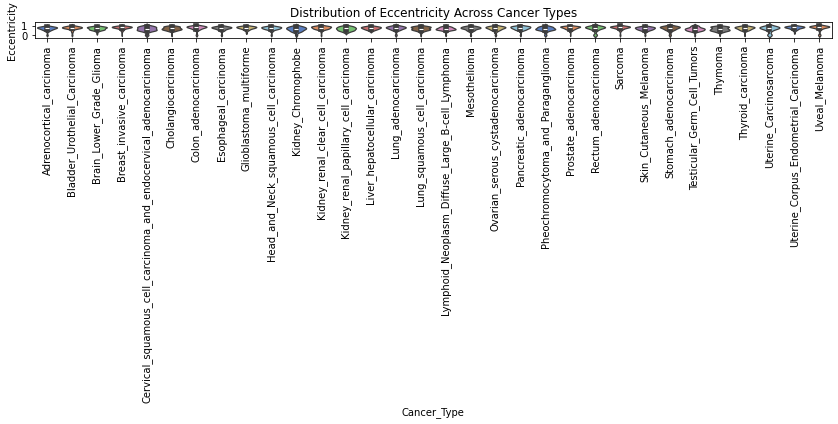

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/1423303821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Cancer_Type", y=feature, data=df, palette="muted")


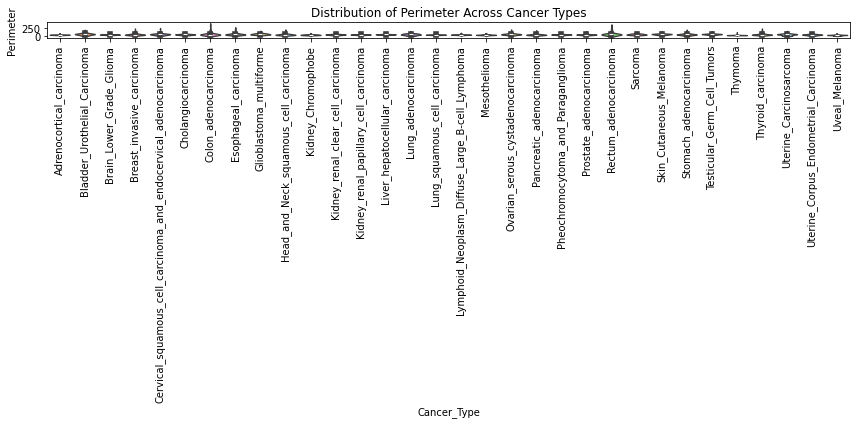

/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_21350/1423303821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Cancer_Type", y=feature, data=df, palette="muted")


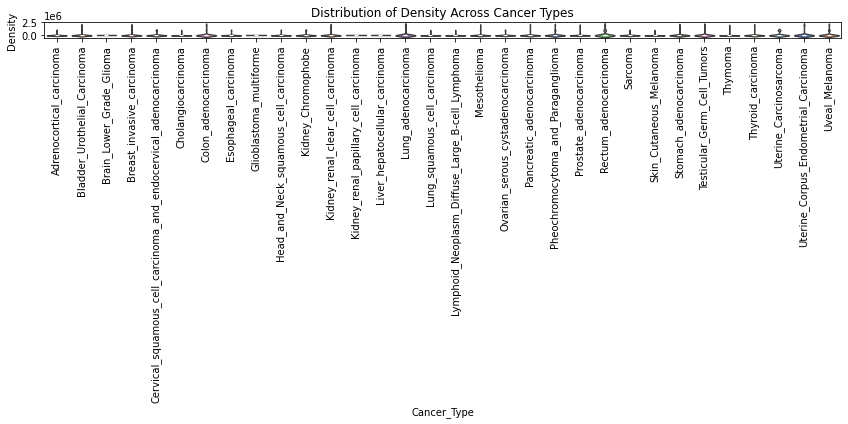

In [7]:
features = ["Area", "Eccentricity", "Perimeter", "Density"]

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Cancer_Type", y=feature, data=df, palette="muted")
    plt.title(f"Distribution of {feature} Across Cancer Types")
    plt.ylabel(feature)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [16]:
for region in regionprops(labeled_mask):
    # Calculate morphological features
    area = region.area
    eccentricity = region.eccentricity
    perimeter = region.perimeter
    density = area / (perimeter + 1e-6)  # Avoid division by zero
    convex_area = region.convex_area
    solidity = area / (convex_area + 1e-6)
    aspect_ratio = region.major_axis_length / (region.minor_axis_length + 1e-6)
    
    # Save the features with the associated cancer type
    data.append({
        "Cancer_Type": labels[idx],
        "Area": area,
        "Eccentricity": eccentricity,
        "Perimeter": perimeter,
        "Density": density,
        "Convex_Area": convex_area,
        "Solidity": solidity,
        "Aspect_Ratio": aspect_ratio
    })

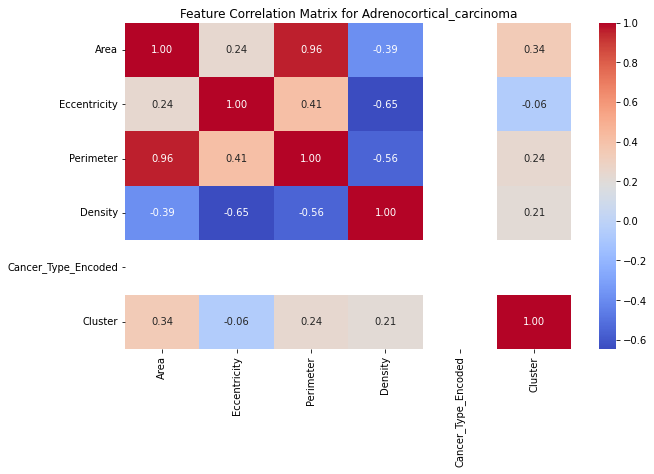

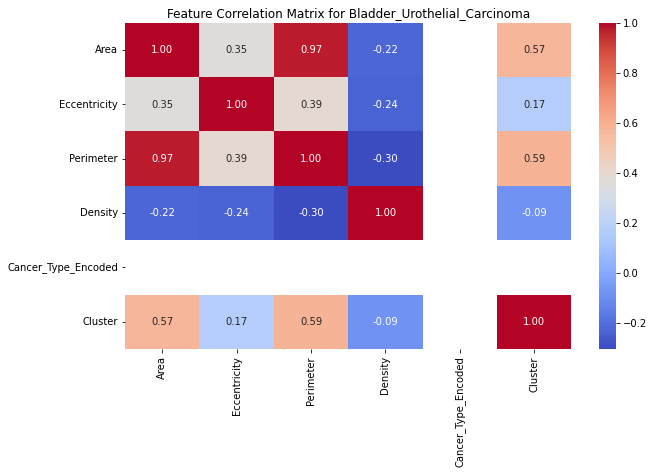

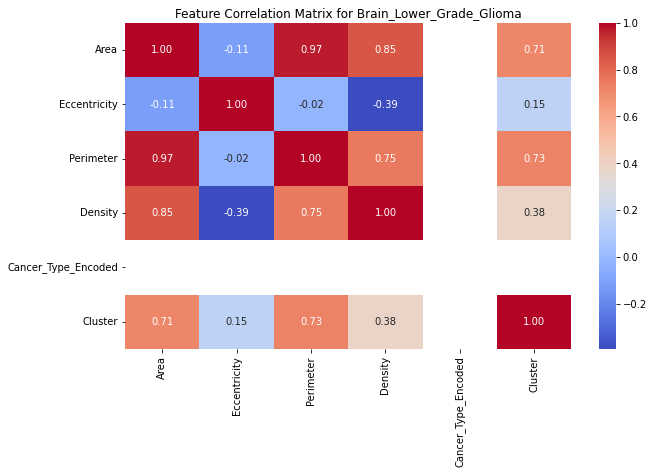

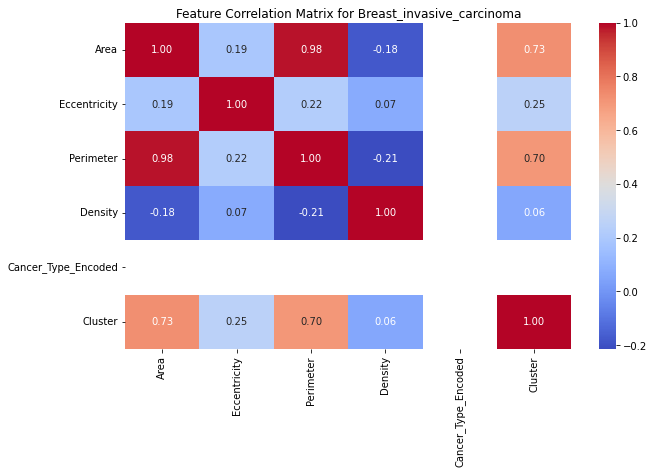

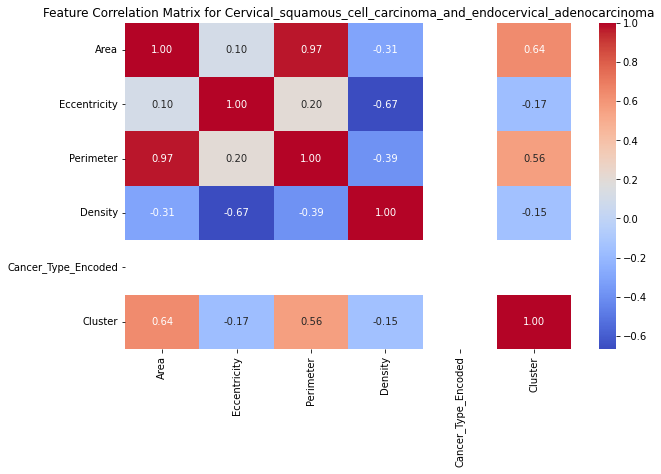

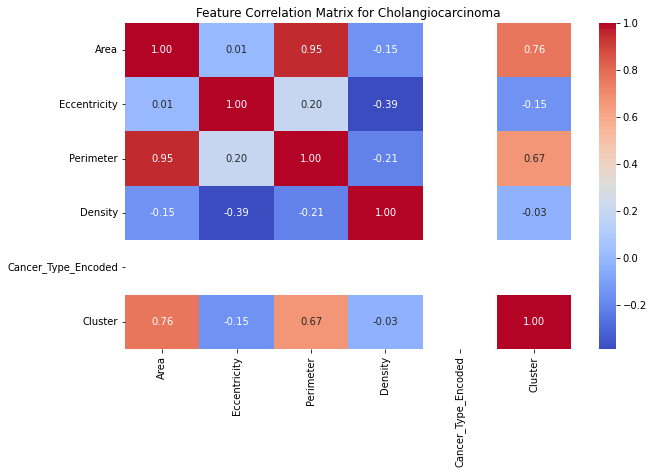

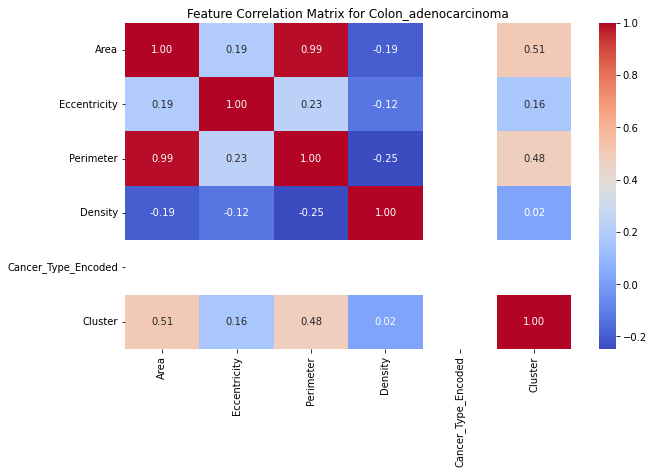

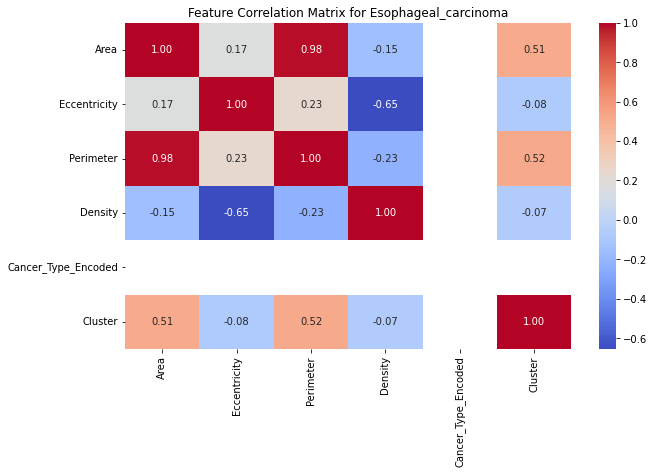

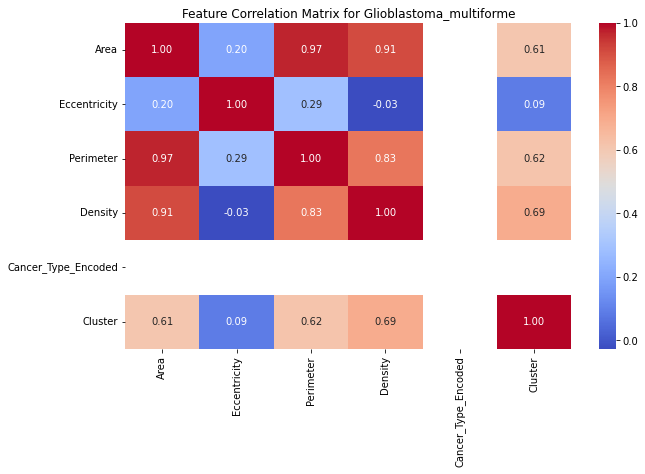

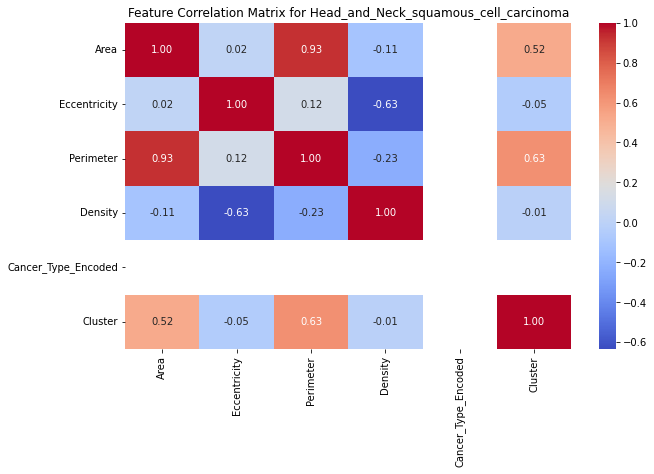

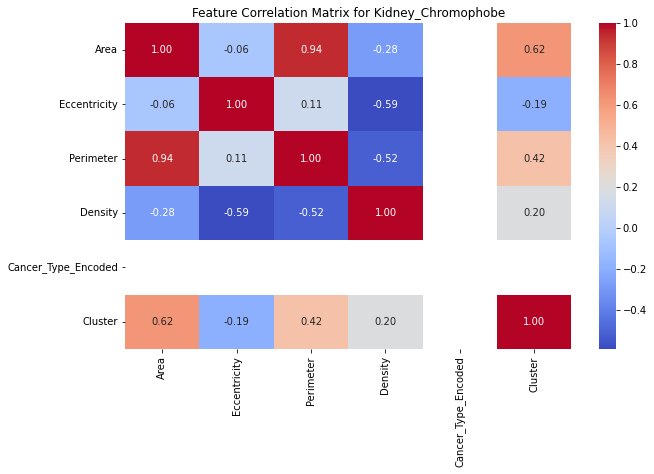

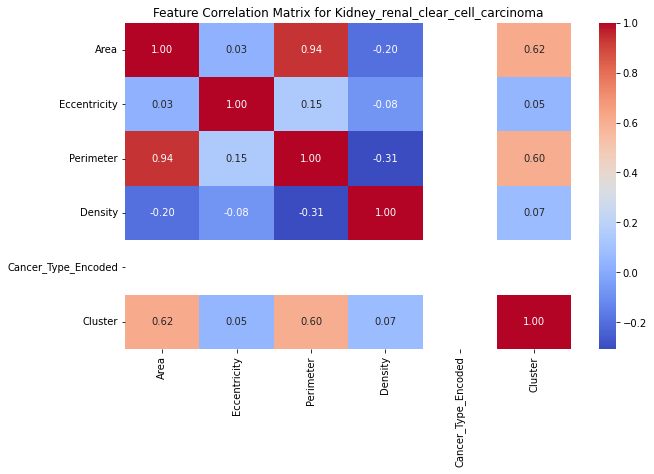

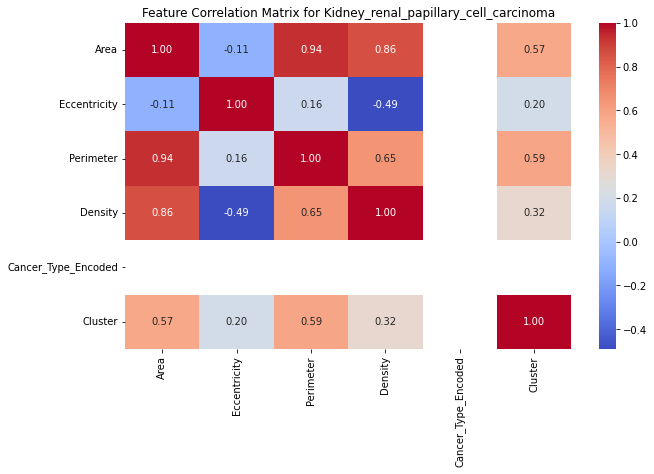

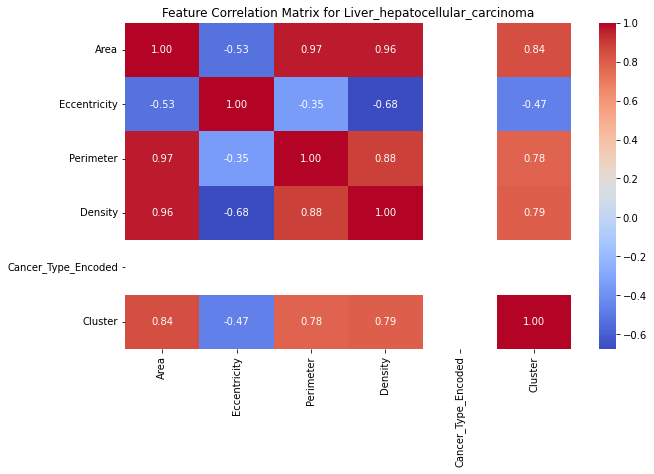

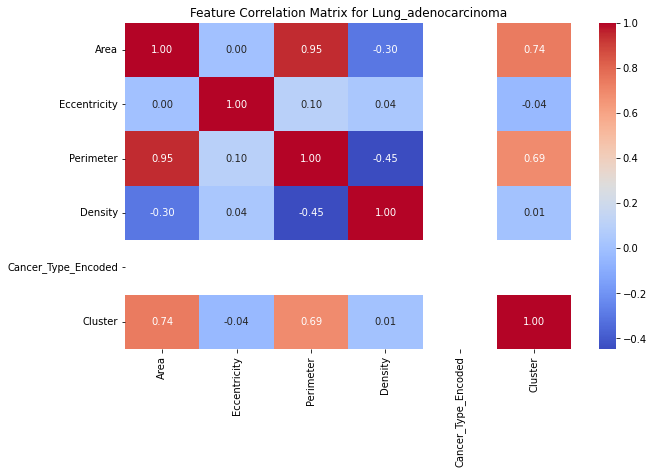

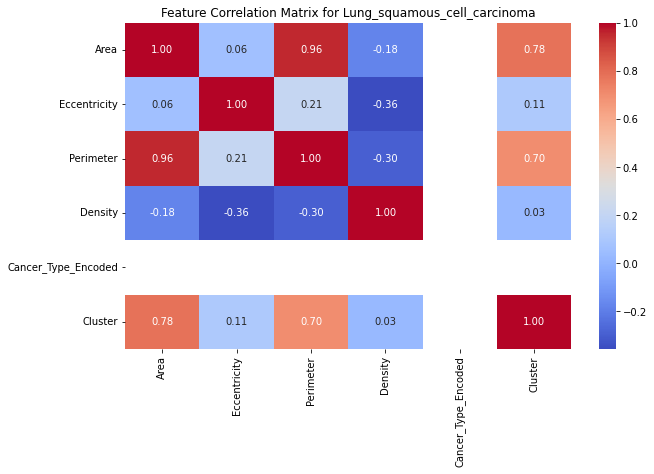

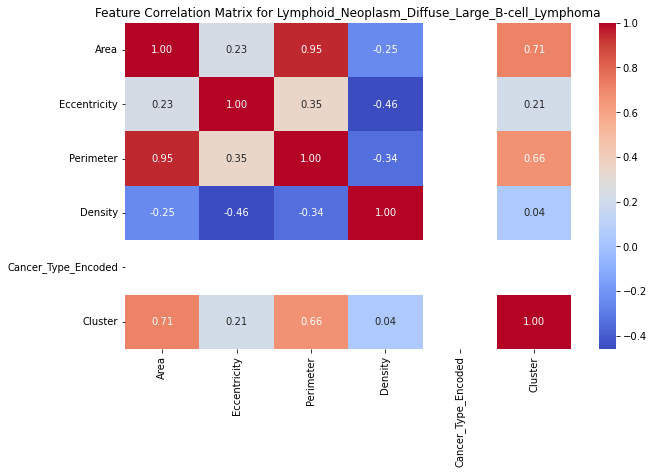

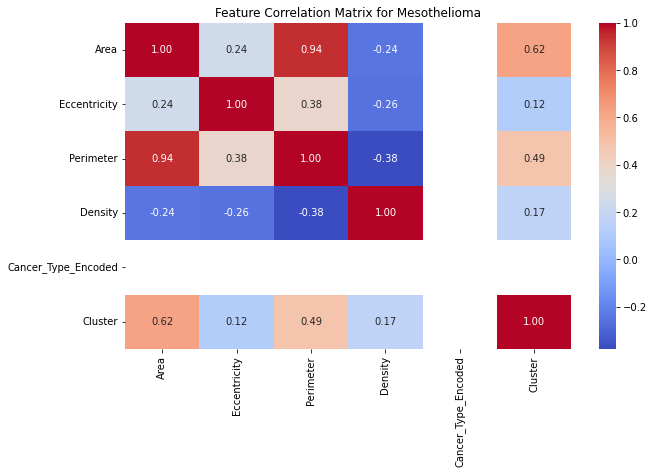

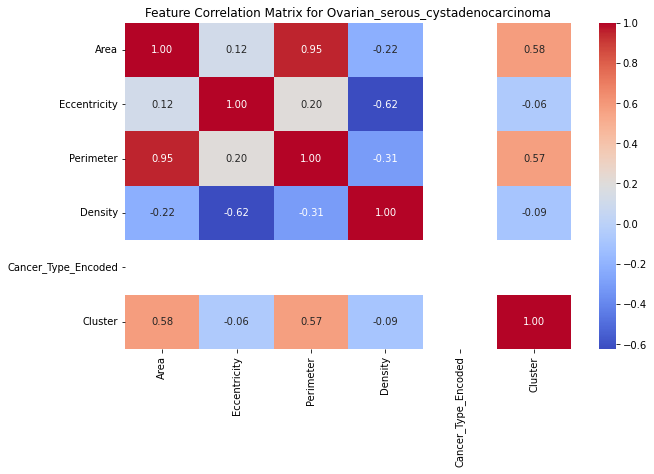

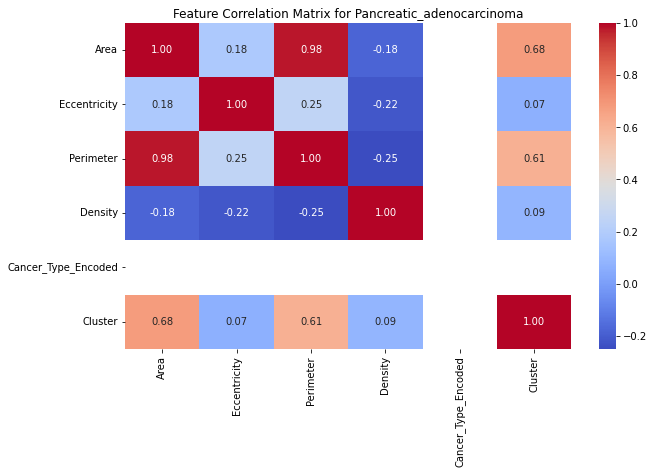

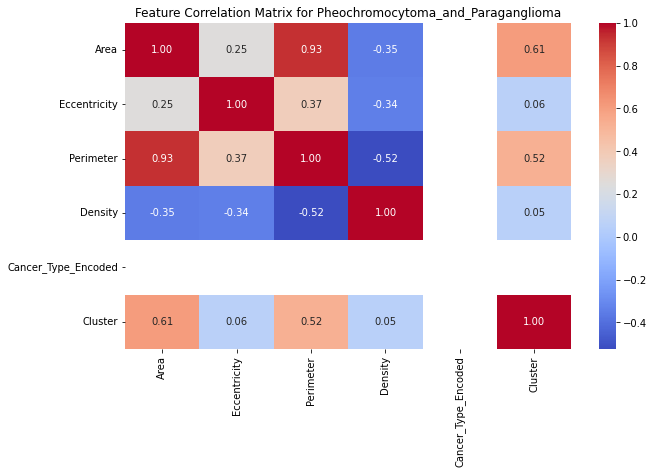

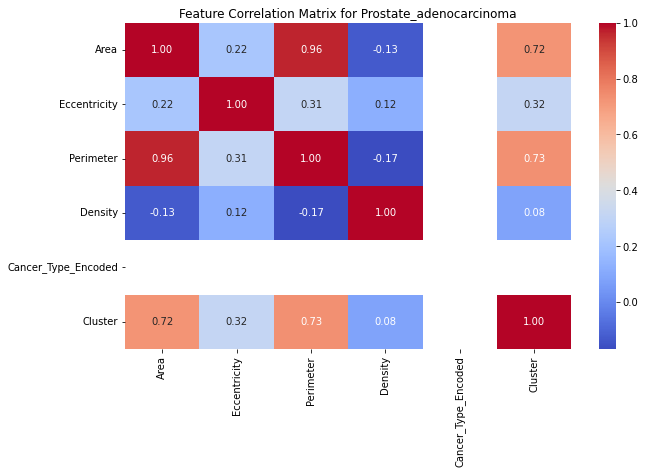

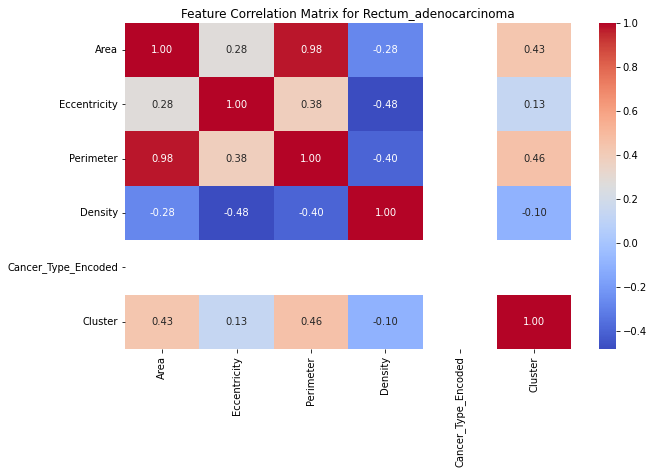

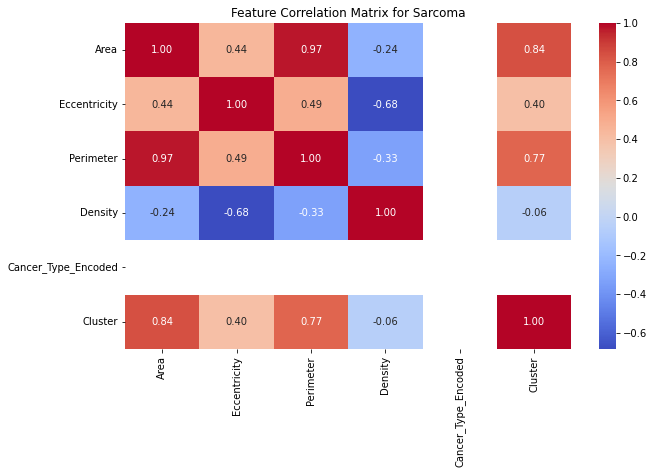

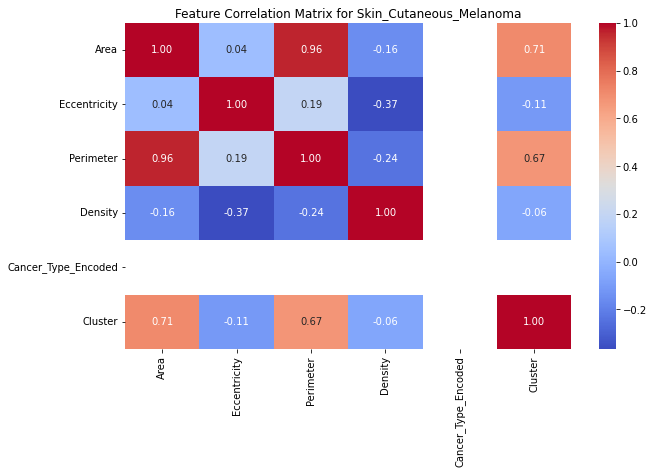

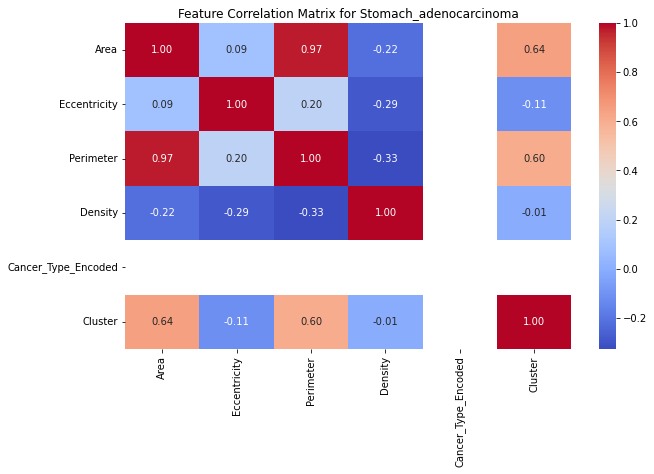

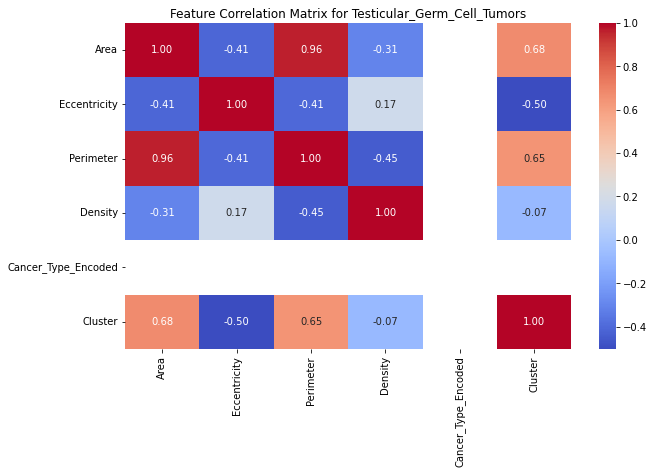

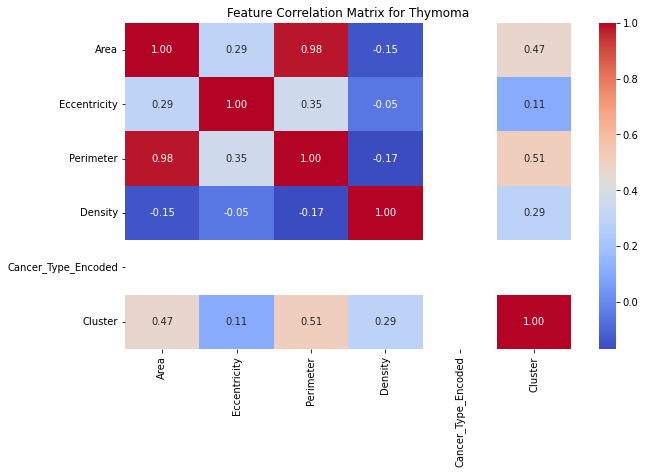

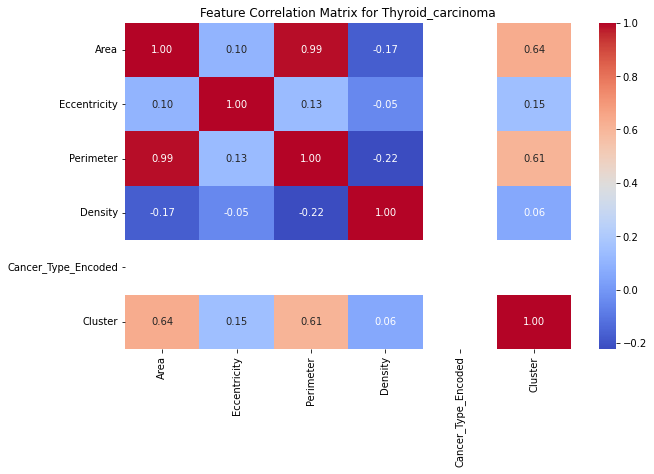

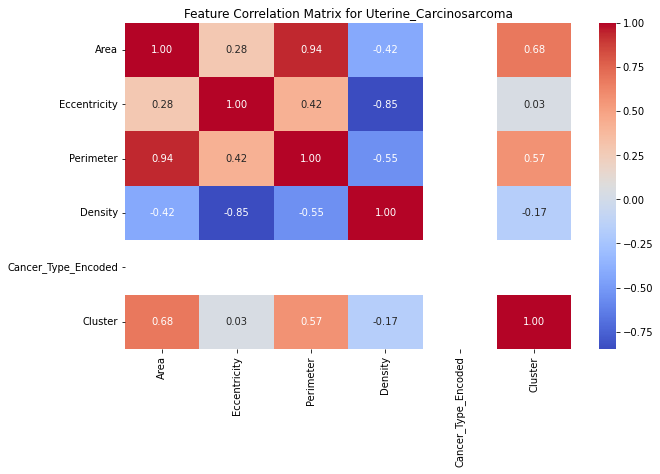

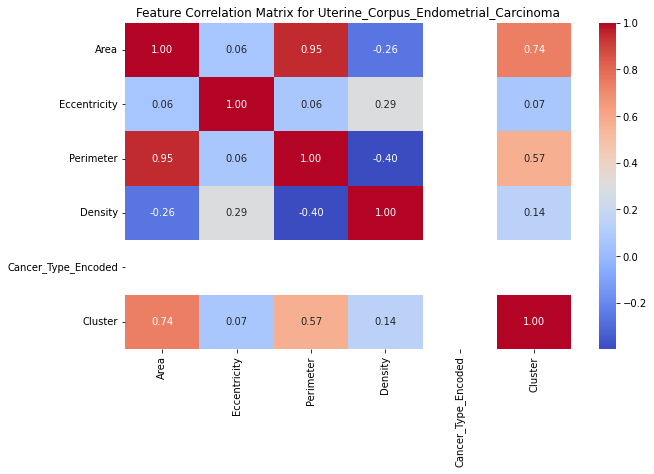

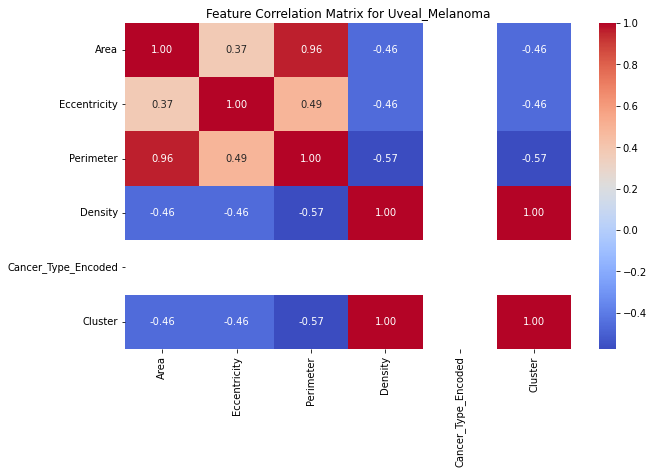

In [17]:
for cancer_type, group in df.groupby("Cancer_Type"):
    correlation_matrix = group.drop("Cancer_Type", axis=1).corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Feature Correlation Matrix for {cancer_type}")
    plt.show()